In [ ]:
!nvidia-smi

Mon Apr 24 09:50:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random
from tqdm.auto import tqdm

In [ ]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# We transform them to tensors
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# torchvision.datasets.MNIST outputs a set of PIL images
# Load and transform data
MNIST_train = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=train_transforms)
MNIST_trainset, MNIST_valset = torch.utils.data.random_split(MNIST_train, [55000, 5000])
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=test_transforms)   

100%|██████████| 9912422/9912422 [00:00<00:00, 100632007.19it/s]


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 128050416.30it/s]


Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27800678.53it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14465093.98it/s]


Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



In [ ]:
class RandomMNISTDataset(Dataset):
  def __init__(self, MNISTDataset):
    self.MNISTDataset = MNISTDataset

  def __getitem__(self, index):
    image = self.MNISTDataset[index][0]
    label = self.MNISTDataset[index][1]
    label_one_hot = F.one_hot(torch.tensor(label), 10)

    return image, label, label_one_hot

  def __len__(self):
    return len(self.MNISTDataset)

In [ ]:
train_dataset = RandomMNISTDataset(MNIST_trainset)
val_dataset = RandomMNISTDataset(MNIST_valset)
test_dataset = RandomMNISTDataset(MNIST_testset)

In [ ]:
print(f'The number of images in train dataset - {len(train_dataset)}')
print(f'The number of images in val dataset - {len(val_dataset)}')

print(f'The number of images in test dataset - {len(test_dataset)}')

The number of images in train dataset - 55000
The number of images in val dataset - 5000
The number of images in test dataset - 10000


In [ ]:
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128)
test_loader = DataLoader(test_dataset,batch_size=128)

In [ ]:
dataiter = iter(train_loader)
images, labels, label_one_hot = next(dataiter)

print('Images: ', images.shape)
print('Labels: ', labels.shape)
print(f'label_one_hot : {label_one_hot.shape}')

print('\nLabels: ', labels[0:3])
print(f'label_one_hot : {label_one_hot[0:3]}')

Images:  torch.Size([128, 1, 28, 28])
Labels:  torch.Size([128])
label_one_hot : torch.Size([128, 10])

Labels:  tensor([6, 3, 3])
label_one_hot : tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


In [ ]:
class Encoder(nn.Module):
    """
    Creates the Encoder

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator
    """
    def __init__(self, nc: int = 1, ndf: int = 16, z_dim: int = 256):
        super(Encoder, self).__init__()

        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=3, stride=1, padding=1, bias=False),          # 1x28x28   -> 16x28x28
            nn.BatchNorm2d(ndf),
            nn.ReLU(True),
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=3, stride=1, padding=1, bias=False),     # 16x28x28  -> 32x28x28
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),            
            nn.MaxPool2d(2, 2),                                                                                        # 32x28x28  -> 32x14x14
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=3, stride=1, padding=1, bias=False),      # 32x14x14  -> 64x14x14
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),            
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=3, stride=1, padding=1, bias=False),     # 64x14x14  -> 128x14x14
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU(True),            
            nn.MaxPool2d(2, 2),                                                                                        # 128x14x14  -> 128x7x7
        )

        self.gap = nn.AdaptiveAvgPool2d(1)                                 # 128x1x1

        self.mu = nn.Conv2d(ndf * 8, z_dim, 1, bias=False)                 # 128x1x1 -> 1024x1x1
        self.logvar = nn.Conv2d(ndf * 8, z_dim, 1, bias=False)             # 128x1x1 -> 1024x1x1

    def forward(self, input):
        out = self.main(input)                      # 128x7x7 
        out = self.gap(out)                         # 128x1x1
        mu = self.mu(out)                           # 1024x1x1
        logvar = self.logvar(out)                   # 1024x1x1
        return mu, logvar                           # 1024x1x1, 1024x1x1

In [ ]:
class Decoder(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 1, ngf: int = 16, z_dim: int = 256):
        super(Decoder, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=ngf * 8, kernel_size=7, stride=1),    #1024x1x1 -> 128x7x7
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=2, stride=2),  #128x7x7 -> 64x14x14
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=2, stride=2),  #64x14x14 -> 32x28x28
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=3, stride=1, padding=1),    #32x28x28 -> 16x28x28
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Conv2d(in_channels=ngf, out_channels=nc, kernel_size=3, stride=1, padding=1),         #16x28x28 -> 1x28x28
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class MNISTVAE(nn.Module):
    def __init__(self, nc: int = 1, nf: int = 16, z_dims: int = 256):
        super(MNISTVAE, self).__init__()

        self.encoder = Encoder(nc, nf, z_dims)
        self.decoder = Decoder(nc, nf, z_dims)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def reparam_like_train(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, input):
        mu, logvar = self.encoder(input)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar

In [ ]:
# move the model to the specified device
model = MNISTVAE(nc=1, nf=16, z_dims=256).to(device)
input = torch.randn(1, 1, 28, 28).to(device)
[x.shape for x in model(input)]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 256, 1, 1]),
 torch.Size([1, 256, 1, 1])]

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,814,995 trainable parameters


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,608
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,432
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
           Conv2d-11          [-1, 128, 14, 14]          73,728
      BatchNorm2d-12          [-1, 128, 14, 14]             256

In [ ]:
bce_loss = nn.BCEWithLogitsLoss() 

def vae_gaussian_kl_loss(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    return KLD.mean()

def reconstruction_loss_bce(x_reconstructed, x):
    return bce_loss(x_reconstructed, x)

def reconstruction_loss_mse(x_reconstructed, x):
    return torch.sum(F.mse_loss(x_reconstructed, x, reduction='none'), dim=(1, 2, 3)).mean()

def kl_divergence_loss(mean, logvar):
    return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

def loss_function(y_pred, y_true):

    recon_x, mu, logvar = y_pred

    # recon_loss = reconstruction_loss_mse(recon_x, y_true)

    recon_loss = reconstruction_loss_bce(recon_x, y_true)

    kld_loss = vae_gaussian_kl_loss(mu, logvar)

    return recon_loss + kld_loss

In [ ]:
input = torch.randn(32, 1, 28, 28).to(device)
y_true = torch.randn(32, 1, 28, 28).to(device)
output = model(input)
loss = loss_function(output, y_true)
loss

tensor(24074.4766, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # set the model in training model
    model.train()

    epoch_loss = 0

    pbar = tqdm(train_loader)

    # run for all the data in train_loader
    for batch_idx, (data, target, label_one_hot) in enumerate(train_loader):

        # fetch the data and the target values
        target = target.type(torch.LongTensor)
        label_one_hot = label_one_hot.type(torch.LongTensor)

        # move the data to device
        data, target, label_one_hot = data.to(device), target.to(device), label_one_hot.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass the model with the data
        output= model(data)#,label_one_hot)

        # compute the loss occured
        loss = loss_function(output, data)

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()

        pbar.set_description(desc=f'Loss={loss.item() :0.4f} Batch={batch_idx}')    

    train_loss = epoch_loss / len(train_loader)
    print(f'Train set: Average loss for epoch : {train_loss: .4f} len(train_loader) : {len(train_loader)'.format(train_loss))

    return train_loss

In [ ]:
# move the model to the specified device
model = MNISTVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# set the number of epochs to train for
num_epoch = 10

train_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)

    train_loss_values.append(train_loss) 


Epoch 1 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  2.6145 len(train_loader) : 430

Epoch 2 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6639 len(train_loader) : 430

Epoch 3 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6444 len(train_loader) : 430

Epoch 4 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6397 len(train_loader) : 430

Epoch 5 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6375 len(train_loader) : 430

Epoch 6 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6361 len(train_loader) : 430

Epoch 7 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6351 len(train_loader) : 430

Epoch 8 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6344 len(train_loader) : 430

Epoch 9 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6339 len(train_loader) : 430

Epoch 10 : 


  0%|          | 0/430 [00:00<?, ?it/s]

Train set: Average loss for epoch :  0.6335 len(train_loader) : 430


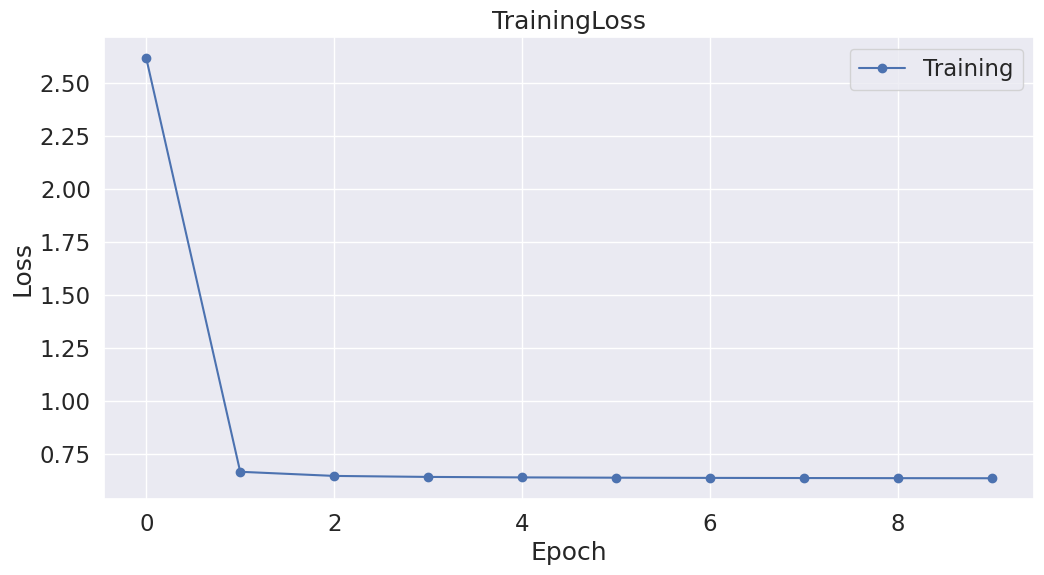

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")

# Label the plot.
plt.title("TrainingLoss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def prediction(image):
    output_1 = model(image.unsqueeze(dim=1).to(device))
    pred_arr = output_1[0].squeeze(0).squeeze(0).detach().cpu().numpy()
    img_arr = image.squeeze(0).detach().cpu().numpy()
    np_arr = np.stack((img_arr, pred_arr))
    plt.figure(figsize=(5, 5))
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        plt.imshow(np_arr[i])
        plt.axis('off')
    plt.show()

Label is : 3


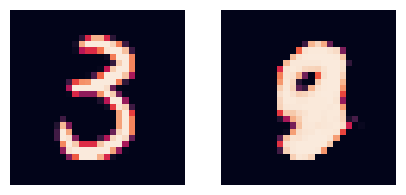

In [ ]:
image, label,_ = test_dataset[random.randint(1,10000)]
print(F'Label is : {label}')
prediction(image)